In [ ]:
# neural network all tools
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,models,transforms
from torch.utils.data.sampler import SubsetRandomSampler
# data visualization tools
import matplotlib.pyplot as plt
import time
import copy
from random import shuffle
import tqdm.notebook as tqdm
#image manipulation tools
import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score,classification_report
from PIL import Image
import cv2
import os
import shutil


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# df = pd.read_excel(r"C:\Users\ayush\Desktop\ml\covid_data_trainer\data\COVID-19_Radiography_Dataset\COVID.metadata.xlsx")
# selected_df= df['FILE NAME']+'.png'
# images = selected_df.values.tolist()
# df['FILE NAME']+'.png'

this is how we import data

In [ ]:
# os.makedirs("./COVID19/train/covid",exist_ok=True)
# os.makedirs("./COVID19/train/normal",exist_ok=True)

In [ ]:
covid_p=("/content/drive/MyDrive/COVID19/train/covid")
normal_p=("/content/drive/MyDrive/COVID19/train/normal")

this is how we coppy data from one directory to ther using os and shulit


In [ ]:
# for image in images:
#     shutil.copy(os.path.join(r'C:\Users\ayush\Desktop\ml\covid_data_trainer\data\COVID-19_Radiography_Dataset\COVID\images', image), os.path.join(covid_p, image))

In [ ]:
# df = pd.read_excel(r"C:\Users\ayush\Desktop\ml\covid_data_trainer\data\COVID-19_Radiography_Dataset\Normal.metadata.xlsx")
# selected_df= df['FILE NAME']+'.png'
# images = selected_df.values.tolist()
# df['FILE NAME']+'.png'

In [ ]:
# images= os.listdir(r"C:\Users\ayush\Desktop\ml\covid_data_trainer\data\COVID-19_Radiography_Dataset\Normal\images")[:3616]
# for image in images:
#     shutil.copy(os.path.join(r'C:\Users\ayush\Desktop\ml\covid_data_trainer\data\COVID-19_Radiography_Dataset\Normal\images', image), os.path.join(normal_p, image))

In [ ]:
DATA_PATH = '/content/drive/MyDrive/COVID19/train'

In [ ]:
class_names = os.listdir(DATA_PATH)
image_count = {}
for i in class_names:
    image_count[i]= len(os.listdir(os.path.join(DATA_PATH,i)))
image_count

{'covid': 3626, 'normal': 3616}

Plotting Distribution of Each Classes

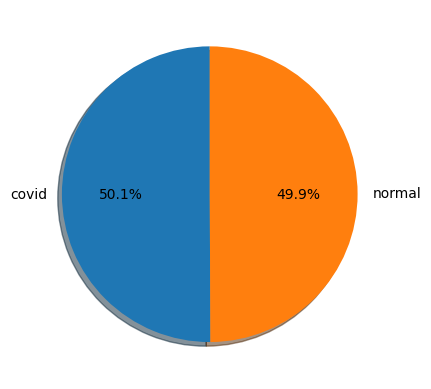

In [ ]:
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.show()

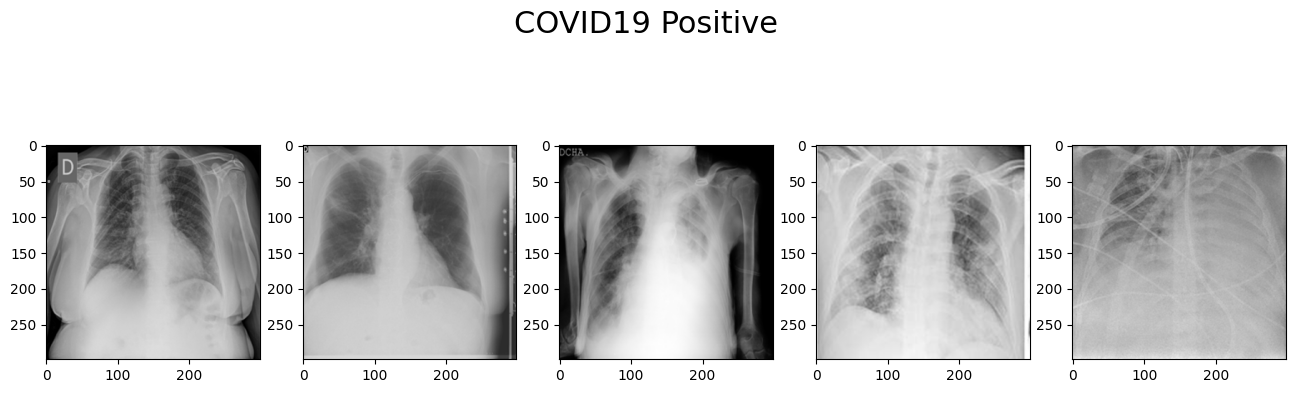

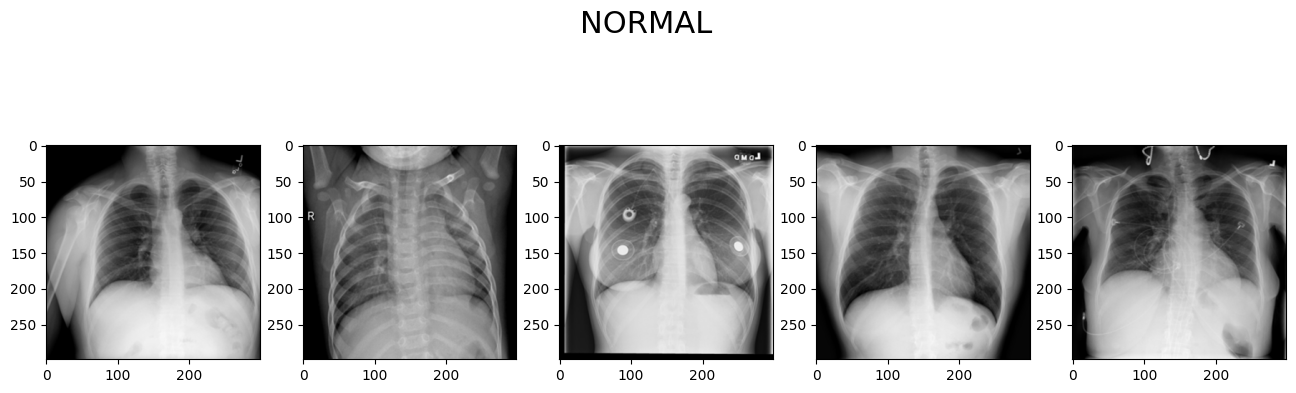

In [ ]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Positive", size=22)
img_paths = os.listdir(covid_p)
shuffle(img_paths)

for i,image in enumerate(img_paths[:5]):
    img = cv2.imread(os.path.join(covid_p, image))
    plt.subplot(1,5, i+1)
    plt.imshow(img)
# fig.show()

fig = plt.figure(figsize=(16,5))
fig.suptitle("NORMAL", size=22)
img_paths = os.listdir(normal_p)
shuffle(img_paths)
for i,image in enumerate(img_paths[:5]):
    img = cv2.imread(os.path.join(normal_p, image))
    plt.subplot(1,5, i+1)
    plt.imshow(img)
# fig.show()

In [ ]:
#Statistics Based on ImageNet Data for Normalisation
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {"train":transforms.Compose([
                    transforms.Resize((224,224)),
                    #Resizes all images into same dimension
                    transforms.RandomRotation(10),
                    # Rotates the images upto Max of 10 Degrees
                    transforms.RandomHorizontalFlip(p=0.4),
                    #Performs Horizantal Flip over images
                    transforms.ToTensor(),
                    # Coverts into Tensors
                    transforms.Normalize(mean = mean_nums, std=std_nums)]),
                    # Normalizes
                    "val": transforms.Compose([
                    transforms.Resize((224,224)),
                    #Performs Crop at Center and resizes it to 150x150
                    transforms.ToTensor(),
                    transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])}

In [ ]:
def load_split_train_test(datadir, valid_size=.2):
    train_data = datasets.ImageFolder(datadir, transform=data_transforms['train'])
    test_data = datasets.ImageFolder(datadir, transform=data_transforms['val'])
    print(train_data)
    num_train = len(train_data)
    indexes = list(range(num_train))
    split = int(np.floor(valid_size*num_train))
    np.random.shuffle(indexes)
    train, test = indexes[split:], indexes[:split]
    dataset_size = {"train": len(train), "val": len(test)}
    # Sampler for splitting train and val images
    train_sampler = SubsetRandomSampler(train)
    test_sampler = SubsetRandomSampler(test)
    trainloader = torch.utils.data.DataLoader(train_data,
                                              sampler=train_sampler, batch_size=6)
    # DataLoader provides data from traininng and validation in batches
    testloader = torch.utils.data.DataLoader(test_data,
                                             sampler=test_sampler, batch_size=6)
    return trainloader, testloader, dataset_size


trainloader, valloader, dataset_size = load_split_train_test(DATA_PATH, .2)
dataloaders = {"train": trainloader, "val": valloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train', 'val']}
class_names = trainloader.dataset.classes
print(class_names)


Dataset ImageFolder
    Number of datapoints: 7242
    Root location: /content/drive/MyDrive/COVID19/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.4)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
['covid', 'normal']


In [ ]:
def show_images(images, labels, preds, t):
    plt.figure(figsize=(20, 9))
    plt.suptitle(t, size=22)
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks = [], yticks = [])
        image = image.numpy().transpose((1, 2, 0))
        mean  = np.array([0.485, 0.456, 0.406])
        std   = np.array([0.229, 0.224, 0.225])
        image = image*std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col   = 'green'
        if preds[i] != labels[i]:
            col = 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color = col)
    plt.tight_layout()
    plt.show()

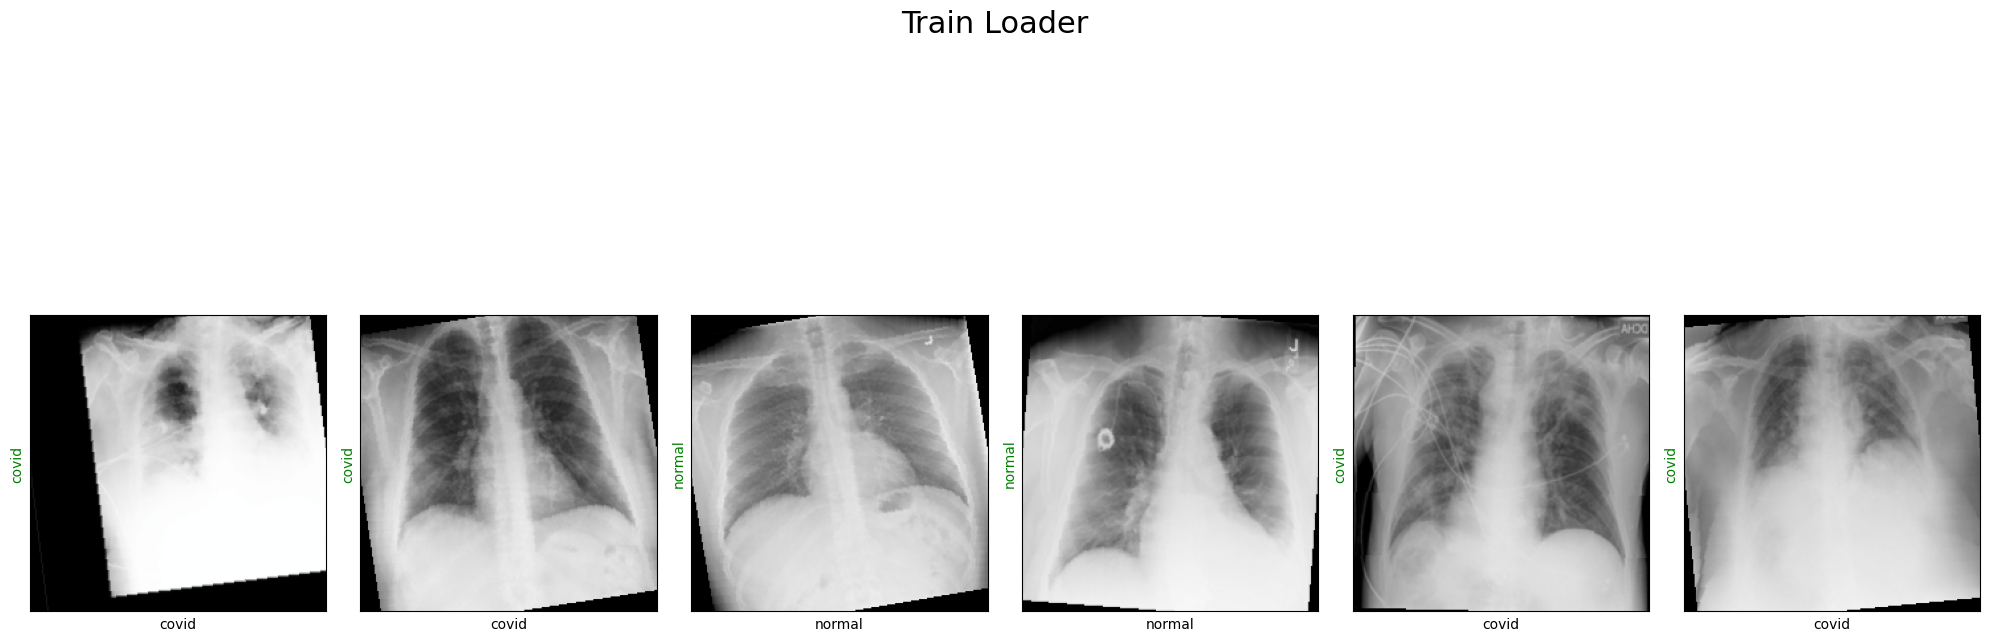

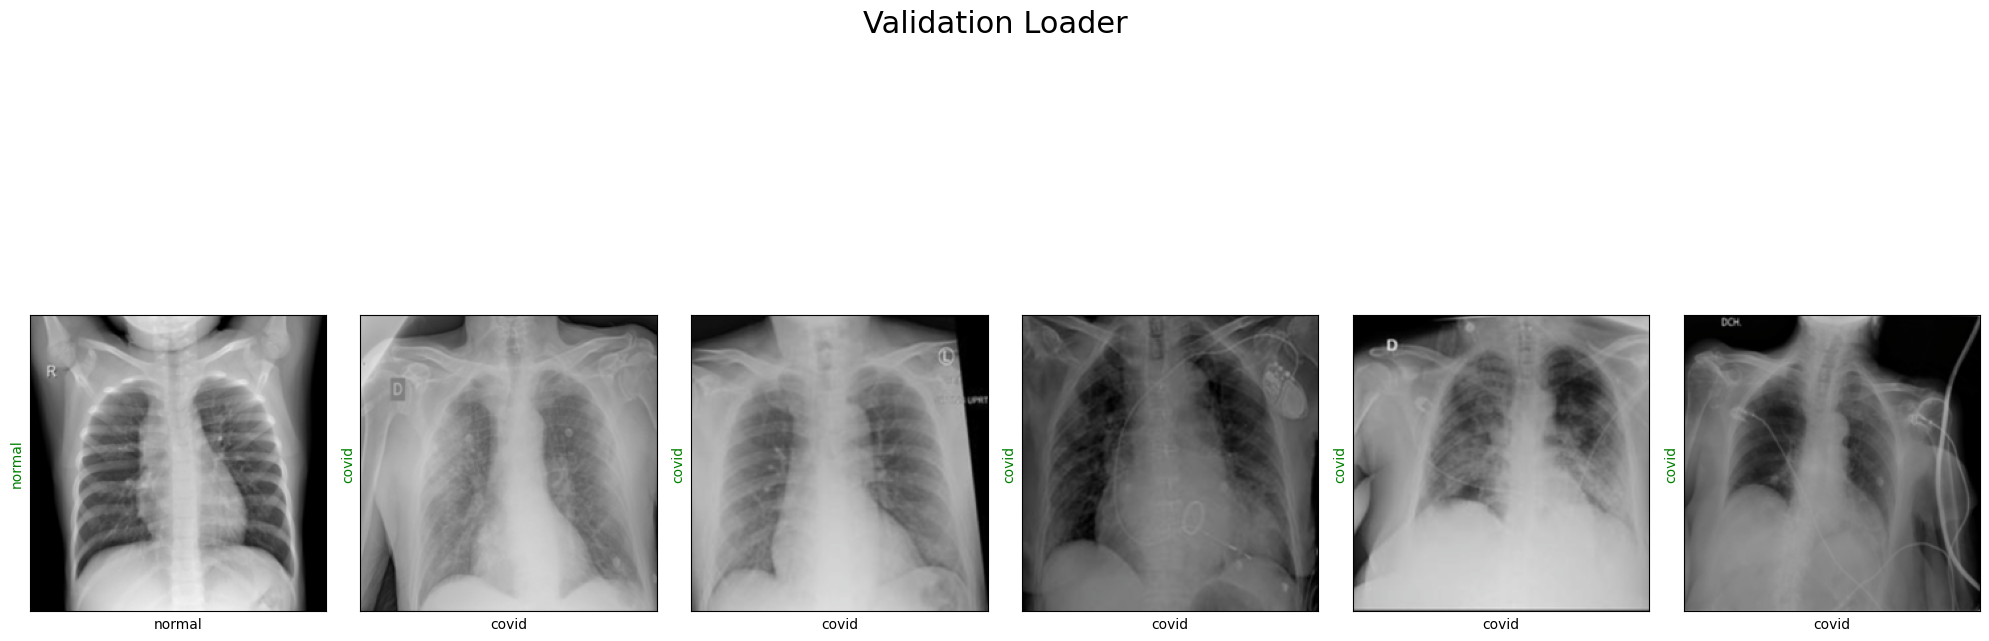

In [ ]:
images, labels = next(iter(dataloaders["train"]))
show_images(images, labels, labels,"Train Loader")
images, labels = next(iter(dataloaders["val"]))
show_images(images, labels, labels,"Validation Loader")

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
resnet18.fc = torch.nn.Linear(in_features = 512, out_features = 2)
loss_fn     = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.Adam(resnet18.parameters(), lr = 3e-5)

In [ ]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dataloaders['val']))
    outputs  = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds, "predicted labels")

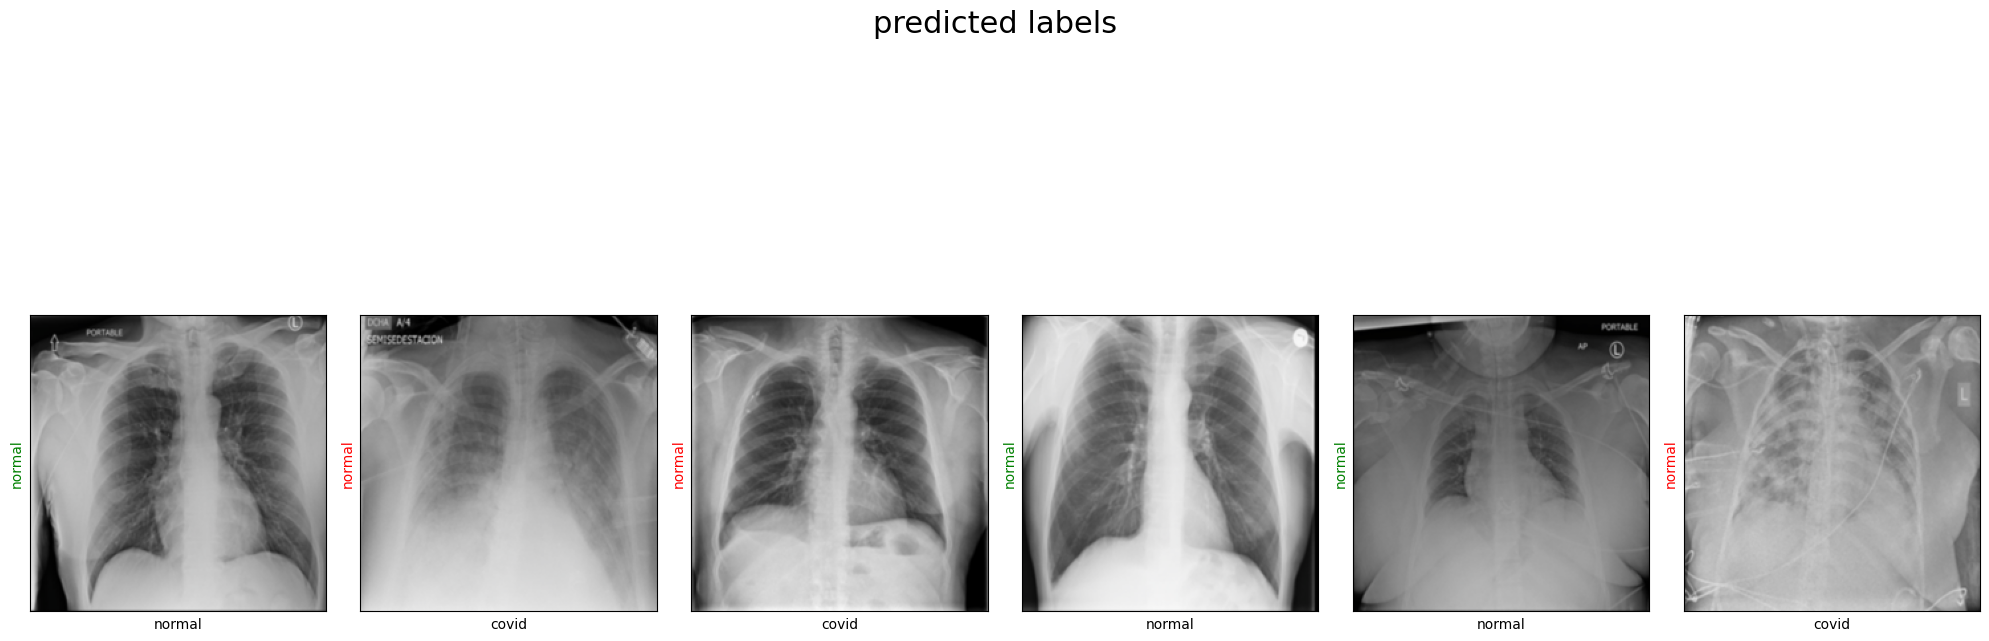

In [ ]:
show_preds()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
len(valloader)

242

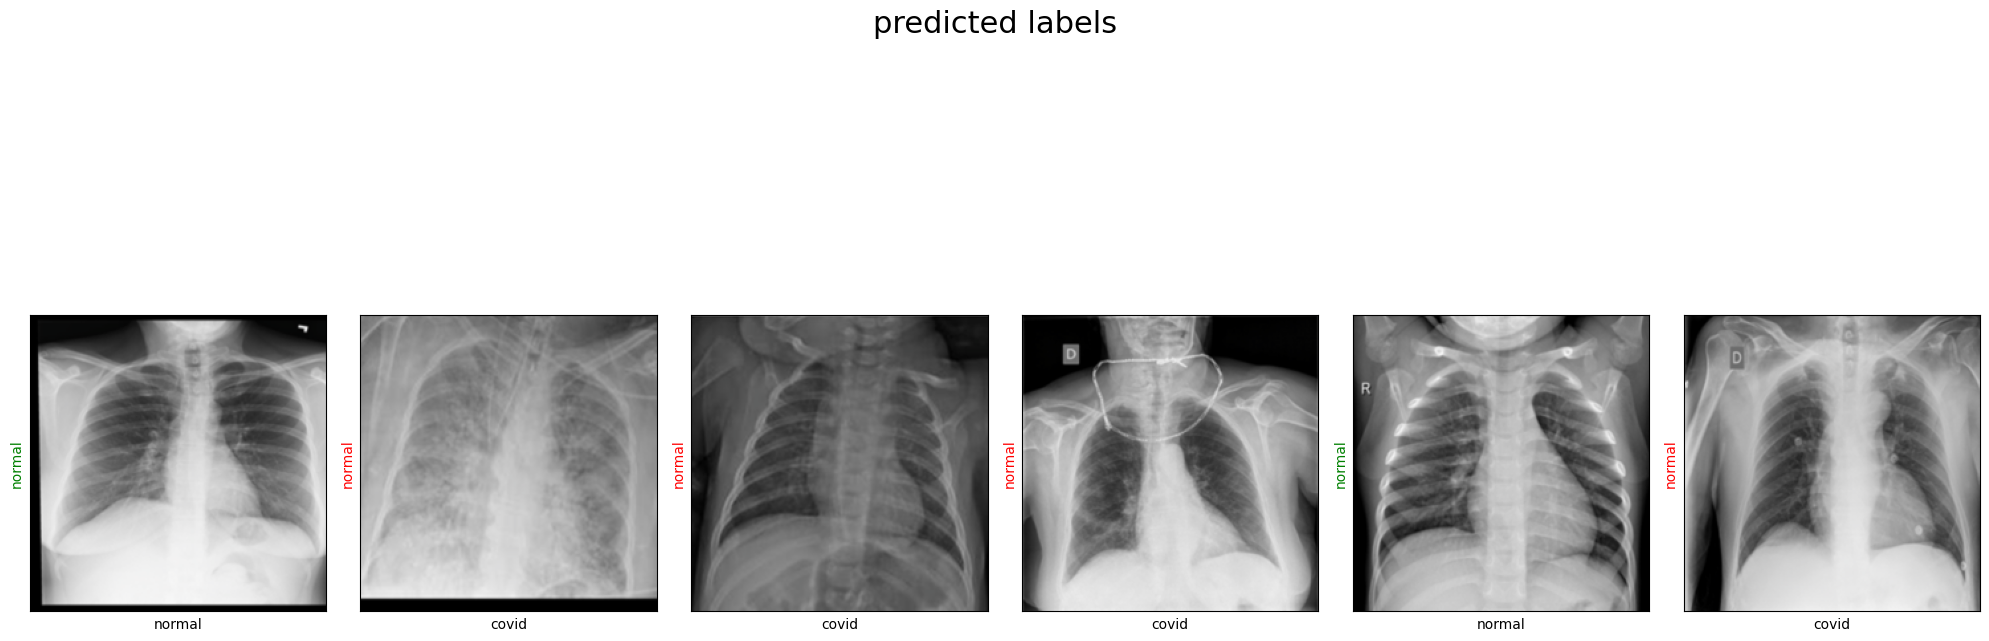

calculating model accuracy before training (should be 1/3 for 3 classes)....
Accuracy of un-trained model: 17.1818


In [ ]:
show_preds()
print('calculating model accuracy before training (should be 1/3 for 3 classes)....')
accuracy = 0
# Evaluate accuracy of non-trained model
resnet18.eval()
for val_step, (images, labels) in enumerate(valloader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = resnet18(images)
    _, preds = torch.max(outputs, dim=1)
    accuracy += sum((preds == labels).cpu().numpy())
accuracy = accuracy / (len(valloader)*6)
print(f'Accuracy of un-trained model: {accuracy:.4f}')

In [ ]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dataloaders['train']):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(valloader):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(valloader)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 0.7950, Accuracy: 2.8636


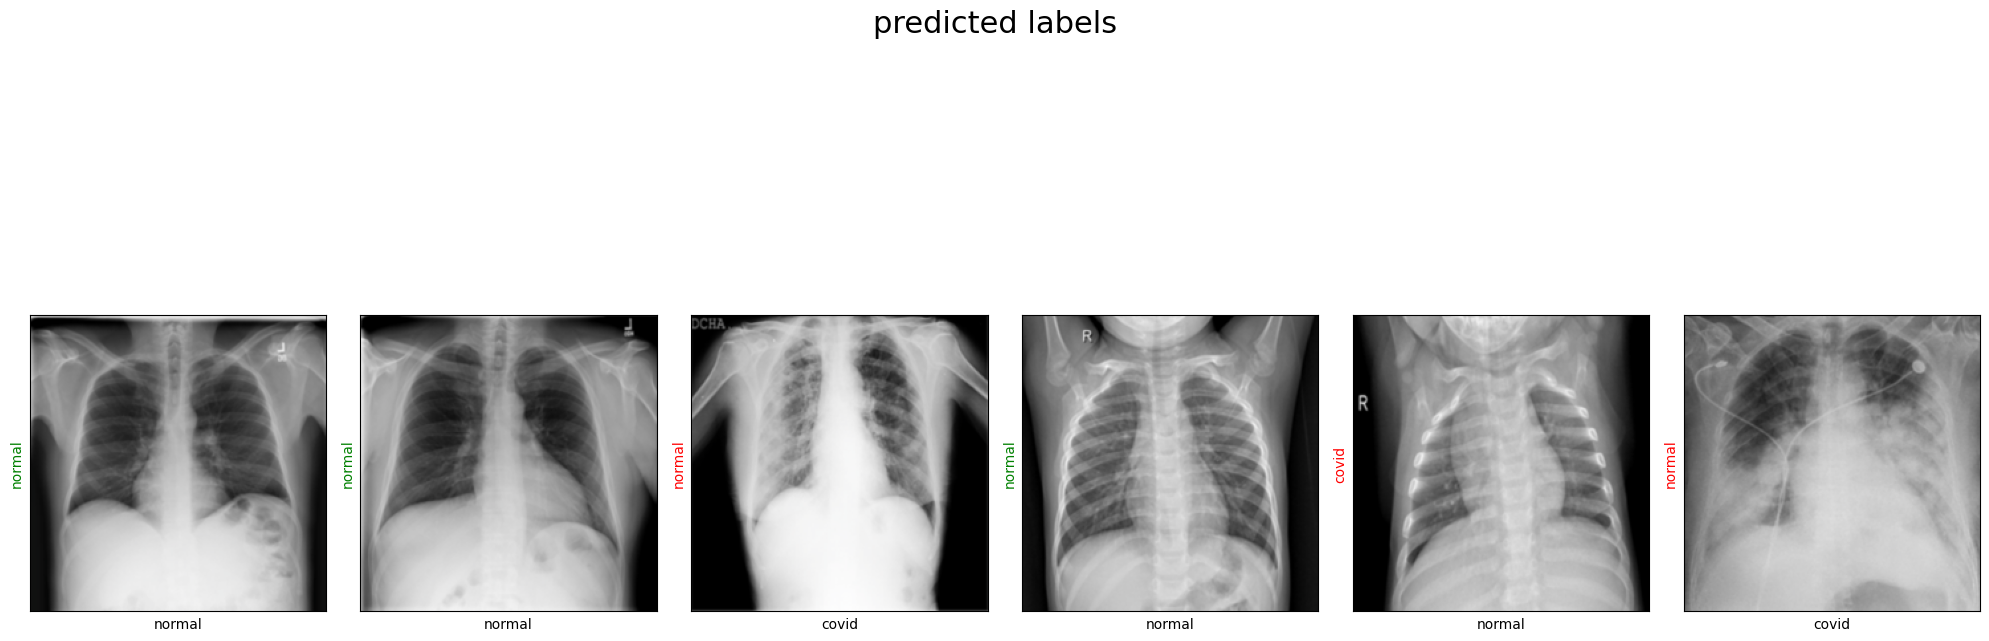

Performance condition satisfied, stopping..


In [ ]:
train(epochs=1)

In [ ]:
def show_images(images, labels, preds):
    plt.figure(figsize=(20,10))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

In [ ]:
def show_preds():
    resnet18.cuda().eval()
    images, labels = next(iter(dataloaders['val']))
    images = images.to(device)
    outputs = resnet18(images.cuda())
    _, preds = torch.max(outputs, 1)
    show_images(images.cpu(), labels.cpu(), preds.cpu())

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
class VGG16_Model(nn.Module):
    # model = models.vgg16()
    # Returns Defined Densenet model with weights trained on ImageNet
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,64, kernel_size=3, stride =1, padding=1,),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,64, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64,128, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128,128, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128,256, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256,256, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256,256, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256,512, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.layer9 = nn.Sequential(
            nn.Conv2d(512,512, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.layer10 = nn.Sequential(
            nn.Conv2d(512,512, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512,512, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.layer12 = nn.Sequential(
            nn.Conv2d(512,512, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.layer13 = nn.Sequential(
            nn.Conv2d(512,512, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(25088, 4096),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096,4096),
            nn.ReLU()
        )
        self.denselayer = nn.Sequential(
            nn.Linear(4096,512),
            nn.Dropout(0.2),
            nn.Linear(512,128),
            nn.Dropout(0.1),
            nn.Linear(128,32),
            nn.Dropout(0.1),
            nn.Linear(32,2),
        )
    def forward(self,x):
        out = self.layer1(x)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out = self.layer3(out)
        #print(out.shape)
        out = self.layer4(out)
        #print(out.shape)
        out = self.layer5(out)
        #print(out.shape)
        out = self.layer6(out)
        #print(out.shape)
        out = self.layer7(out)
        #print(out.shape)
        out = self.layer8(out)
        #print(out.shape)
        out = self.layer9(out)
        #print(out.shape)
        out = self.layer10(out)
        #print(out.shape)
        out = self.layer11(out)
        #print(out.shape)
        out = self.layer12(out)
        #print(out.shape)
        out = self.layer13(out)
        #print(out.shape)
        #print(out.size(0))
        out = out.reshape(out.size(0),-1)
        #print(out.shape)
        out = self.fc(out)
        #print(out.shape)
        out = self.fc1(out)
        #print(out.shape)
        out = self.denselayer(out)
        #print(out.shape)
        return out
    # num_ftrs = model.classifier.in_features
    # Get the number of features output from CNN layer
    # model.classifier = nn.Linear(num_ftrs, len(class_names))
    # Overwrites the Classifier layer with custom defined layer for transfer learning
    # model = model.to(device)
    # Transfer the Model to GPU if available

model = VGG16_Model()

# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss()

# Specify optimizer which performs Gradient Descent
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# Learning Scheduler

In [ ]:
import torchsummary
import numpy as np

In [ ]:
torchsummary.summary(model.to(device),(3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 227, 227]           1,792
       BatchNorm2d-2         [-1, 64, 227, 227]             128
              ReLU-3         [-1, 64, 227, 227]               0
            Conv2d-4         [-1, 64, 227, 227]          36,928
       BatchNorm2d-5         [-1, 64, 227, 227]             128
              ReLU-6         [-1, 64, 227, 227]               0
         MaxPool2d-7         [-1, 64, 113, 113]               0
            Conv2d-8        [-1, 128, 113, 113]          73,856
       BatchNorm2d-9        [-1, 128, 113, 113]             256
             ReLU-10        [-1, 128, 113, 113]               0
           Conv2d-11        [-1, 128, 113, 113]         147,584
      BatchNorm2d-12        [-1, 128, 113, 113]             256
             ReLU-13        [-1, 128, 113, 113]               0
        MaxPool2d-14          [-1, 128,

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('[INFO] :Epoch {}/{}'.format(epoch+1, num_epochs))

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            i=0
            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()
            for i ,(inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients in the Cache.
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    #print(outputs, labels)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    if phase == 'train':
                        scheduler.step()

                    # We want variables to hold the loss statistics
                    current_loss += loss.item() * inputs.size(0)
                    current_corrects += torch.sum(preds == labels.data)
                    val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
                    if(i%20==0):
                        print('=',end='')
                    i+=1
            print('>',end='')
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))

            # EARLY STOPPING
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = model.state_dict()

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:
base_model = train_model(resnet18, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

[INFO] :Epoch 1/10
==========>train Loss: 0.7480 | train Accuracy: 0.7421
===>val Loss: 0.7614 | val Accuracy: 0.7231 | Kappa Score: 0.4350
Val loss Decreased from inf to 0.7614 
Saving Weights... 

[INFO] :Epoch 2/10
==========>train Loss: 0.7411 | train Accuracy: 0.7444
===>val Loss: 0.7593 | val Accuracy: 0.7030 | Kappa Score: 0.4091
Val loss Decreased from 0.7614 to 0.7593 
Saving Weights... 

[INFO] :Epoch 3/10
==========>train Loss: 0.7332 | train Accuracy: 0.7504
===>val Loss: 0.7697 | val Accuracy: 0.6961 | Kappa Score: 0.3955

[INFO] :Epoch 4/10
==========>train Loss: 0.7346 | train Accuracy: 0.7518
===>val Loss: 0.7605 | val Accuracy: 0.7113 | Kappa Score: 0.4267

[INFO] :Epoch 5/10
==========>train Loss: 0.7379 | train Accuracy: 0.7425
===>val Loss: 0.7638 | val Accuracy: 0.7093 | Kappa Score: 0.4153

[INFO] :Epoch 6/10
==========>train Loss: 0.7370 | train Accuracy: 0.7473
===>val Loss: 0.7466 | val Accuracy: 0.7231 | Kappa Score: 0.4368
Val loss Decreased from 0.7593 to 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:730: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


===>val Loss: 0.7605 | val Accuracy: 0.7003 | Kappa Score: 0.3994

[INFO] :Epoch 8/10
==========>train Loss: 0.7367 | train Accuracy: 0.7456
===>val Loss: 0.7593 | val Accuracy: 0.7217 | Kappa Score: 0.4497

[INFO] :Epoch 9/10
==========>train Loss: 0.7405 | train Accuracy: 0.7440
===>val Loss: 0.7658 | val Accuracy: 0.6968 | Kappa Score: 0.3977

[INFO] :Epoch 10/10
==========>train Loss: 0.7304 | train Accuracy: 0.7485
===>val Loss: 0.7625 | val Accuracy: 0.7017 | Kappa Score: 0.3955

Training complete in 128m 33s
Best val loss: 0.7466


visualize_model(base_model)
plt.show()

In [ ]:
visualize_model(base_model)

NameError: name 'base_model' is not defined

In [ ]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

In [ ]:
torch.save(model.state_dict(), "C:\\Users\\ayush\Desktop\ml\covid_data_trainer\\base_model\\base_model.pt",_use_new_zipfile_serialization=False)